In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = catalog.load('master_table')

2021-04-19 16:48:41,550 - kedro.io.data_catalog - INFO - Loading data from `master_table` (ParquetDataSet)...


Clients differ between each other on different levels.    

At this point I want to focus only on the information that says if it is a New customer or if it is Existing Customer.

I don't have a historical transaction for a New customers and in this case they should have a separate model build.
Below I want to check if having at least 1 transaction is enough.     

# Default rate (traget) vs #clients transactions

<AxesSubplot:>

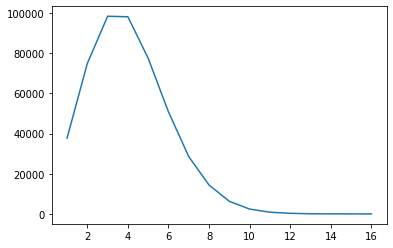

In [3]:
df['rank'].value_counts().sort_index().plot()

For the sake of analysis simplicity I round down transaction to 10.

In [4]:
df.loc[df['rank']>9,'rank'] = 10

2021-04-19 17:11:18,858 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


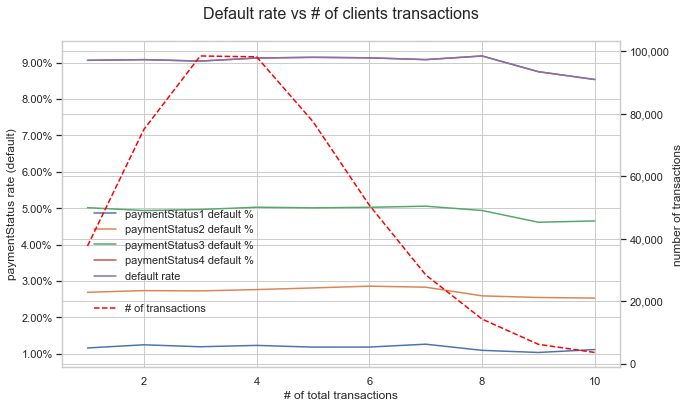

In [7]:
%matplotlib inline
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

df.assign(paymentStatus1=lambda x: x['paymentStatus1']==2).groupby('rank')['paymentStatus1'].mean().sort_index().plot(label='paymentStatus1 default %', ax=ax1)
df.assign(paymentStatus2=lambda x: x['paymentStatus2']==2).groupby('rank')['paymentStatus2'].mean().sort_index().plot(label='paymentStatus2 default %', ax=ax1)
df.assign(paymentStatus3=lambda x: x['paymentStatus3']==2).groupby('rank')['paymentStatus3'].mean().sort_index().plot(label='paymentStatus3 default %', ax=ax1)
df.assign(paymentStatus4=lambda x: x['paymentStatus4']==2).groupby('rank')['paymentStatus4'].mean().sort_index().plot(label='paymentStatus4 default %', ax=ax1)
df.groupby('rank')['default'].mean().sort_index().plot(label='default rate', ax=ax1)

df['rank'].value_counts().sort_index().plot(color='red', label='# of transactions' ,ax=ax2)

ax2.lines[0].set_linestyle("--")

ax1.legend(loc = (.05,.25), frameon = False)
ax2.legend(loc = (.05, .15), frameon = False)

ax1.set(xlabel='# of total transactions', ylabel='paymentStatus rate (default)')
ax2.set(ylabel='number of transactions')

plt.title('Default rate vs # of clients transactions', y=1.05, fontsize = 16)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y))) 
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 

plt.show()


There is no difference in default rate given the number of transactions that customer has already made.     
In reall life it's rarely the case.    


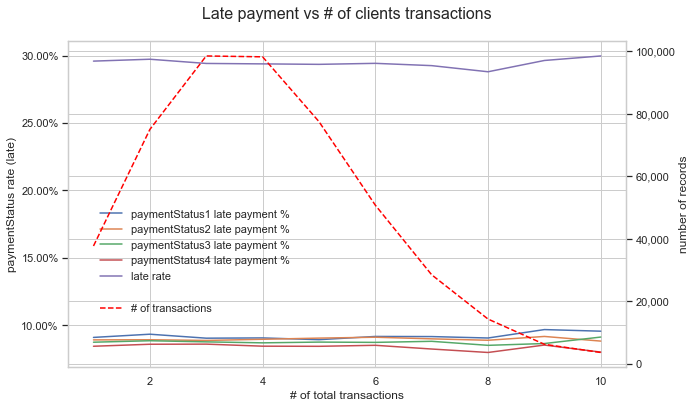

In [8]:
%matplotlib inline
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

df.assign(paymentStatus1=lambda x: x['paymentStatus1']==1).groupby('rank')['paymentStatus1'].mean().sort_index().plot(label='paymentStatus1 late payment %', ax=ax1)
df.assign(paymentStatus2=lambda x: x['paymentStatus2']==1).groupby('rank')['paymentStatus2'].mean().sort_index().plot(label='paymentStatus2 late payment %', ax=ax1)
df.assign(paymentStatus3=lambda x: x['paymentStatus3']==1).groupby('rank')['paymentStatus3'].mean().sort_index().plot(label='paymentStatus3 late payment %', ax=ax1)
df.assign(paymentStatus4=lambda x: x['paymentStatus4']==1).groupby('rank')['paymentStatus4'].mean().sort_index().plot(label='paymentStatus4 late payment %', ax=ax1)
df.groupby('rank')['late'].mean().sort_index().plot(label='late rate', ax=ax1)

df['rank'].value_counts().sort_index().plot(color='red', label='# of transactions' ,ax=ax2)

ax2.lines[0].set_linestyle("--")

ax1.legend(loc = (.05,.25), frameon = False)
ax2.legend(loc = (.05, .15), frameon = False)

ax1.set(xlabel='# of total transactions', ylabel='paymentStatus rate (late)')
ax2.set(ylabel='number of records')

plt.title('Late payment vs # of clients transactions', y=1.05, fontsize = 16)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y))) 
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 

plt.show()


There is no difference in late payments given the number of transactions that customer has already made.     


# Default rate vs "pseudo time"

It is important to be be aware of your target doesn't change over time.
There is no transaction data available, but since transactions ID are increasing, I can asume that the higher ID is, the older transaction is.       
Based on this assumption I'm creating 'pseudo time' dimension to show target behaves over time.


<AxesSubplot:xlabel='pseudo_date'>

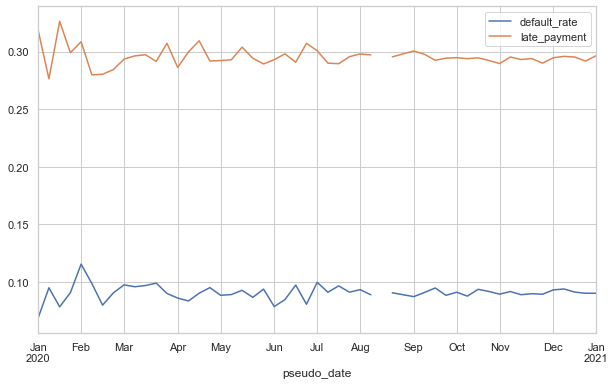

In [10]:
number_of_weeks = 52
fig, ax1 = plt.subplots(figsize=(10,6))

dates = dict([i for i in zip(range(number_of_weeks), pd.date_range(start='2020-01-01', end='2020-12-31',periods=number_of_weeks))])
div = round(df.transactionID.max()/(number_of_weeks-1),0)
df['pseudo_date'] = df.transactionID.apply(lambda x: int(round(x/div,0))).map(lambda x: dates[x])
df.set_index('pseudo_date').resample('W')[['default']].agg(default_rate=('default', 'mean')).plot(ax=ax1)
df.set_index('pseudo_date').resample('W')[['late']].agg(late_payment=('late', 'mean')).plot(ax=ax1)


# Create segments

In [20]:
df_new_customer.shape

(37721, 99)

In [21]:
df_existing_customer.shape

(452775, 99)

In [37]:
df_new_customer = df.loc[df['rank']==1].reset_index(drop=True)
df_existing_customer = df.loc[df['rank']>1].reset_index(drop=True)

In [16]:
df_new_customer.default.mean()

0.09066567694387742

In [17]:
df_existing_customer.default.mean()

0.09097233725360278

In [18]:
df_new_customer.late.mean()

0.2958829299329286

In [19]:
df_existing_customer.late.mean()

0.2942764066037215

Further in this analysis I will focus on Existing Customer

# Data split

In [22]:
params_ds = catalog.load('params:data_set')

2021-04-19 17:38:54,654 - kedro.io.data_catalog - INFO - Loading data from `params:data_set` (MemoryDataSet)...


df_oot   - data set that will allow to check model performance on the latest available data (out of time),    
df_train - dataset for model training,    
df_test  - dataset for model performance assessing (out of sample)    
df_valid - dataset for hp tuning (out of sample),   

In [25]:
params_ds

{'oot': 50000, 'train': 0.7, 'test': 0.2, 'valid': 0.1}

In [26]:
df_oot = df_existing_customer.sort_values('customerID').iloc[-params_ds['oot']:].sort_index()
df_existing_customer = df_existing_customer.sort_values('customerID').iloc[:-params_ds['oot']]

In [27]:
size=df_existing_customer.shape[0]
train_size = int(size * params_ds['train'])
test_size = int(size * params_ds['test'])

df_existing_customer=df_existing_customer.sample(frac=1, random_state=1)
df_train = df_existing_customer.iloc[:train_size].sort_index()
df_test = df_existing_customer.iloc[train_size:(train_size+test_size)].sort_index()
df_valid = df_existing_customer.iloc[(train_size+test_size):].sort_index()


# model lightgbm - no hp, just for feature importance

In [28]:
import numpy as np
from category_encoders import *

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt 

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


In [29]:
categorical_cols = ['sex', 'residentialAddress_clean',
                    'geo_risk_rank','shopID','same_address']
numerical_cols = ['age', 'income', 'price'] + \
    df.filter(regex='(^hist_)|(_lst_)').columns.to_list()
target_column = ['default']



In [30]:
lgb_params = {"seed": 42,
              "objective": "binary", 
              "learning_rate": 0.1,
              "metric":"auc"
              }

In [31]:
transformer = make_pipeline(
    ColumnTransformer([
        ('num','passthrough', numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols),    
    ]),
)

In [32]:
d_train = lgb.Dataset(
    transformer.fit_transform(df_train, df_train['default']), 
    label=df_train['default'], 
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

d_valid = lgb.Dataset(
    transformer.transform(df_valid), 
    label=df_valid['default'], 
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

d_test = lgb.Dataset(
    transformer.transform(df_test), 
    label=df_test['default'], 
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

In [33]:
classifier = make_pipeline(
    ColumnTransformer([
        ('num','passthrough', numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols),       
    ]),
    LGBMClassifier(n_estimators=500, random_state=1, metric= "auc", importance_type='gain')
)

In [34]:
%%time
results=[]

for i in range(1,11): 
    _tmp_target = df.loc[df['rank']==i].reset_index(drop=True)[target_column].values.reshape(-1,)
    oof_pred = cross_val_predict(classifier, 
                                 df.loc[df['rank']==i].reset_index(drop=True), 
                                 _tmp_target, 
                                 cv=5,
                                 method="predict_proba")
    _tmp_roc_score = roc_auc_score(_tmp_target, oof_pred[:,1])
    results += [(i, _tmp_roc_score)]
    print("#{}, Cross validation AUC {:.4f}".format(i, _tmp_roc_score))

    
_tmp_target = df[target_column].values.reshape(-1,)
oof_pred = cross_val_predict(classifier, 
                             df, 
                             _tmp_target, 
                             cv=5,
                             method="predict_proba")
_tmp_roc_score = roc_auc_score(_tmp_target, oof_pred[:,1])
results += [(i, _tmp_roc_score)]
print("#ALL, Cross validation AUC {:.4f}".format(_tmp_roc_score))

#1, Cross validation AUC 0.6159
#2, Cross validation AUC 0.6189
#3, Cross validation AUC 0.6305
#4, Cross validation AUC 0.6392
#5, Cross validation AUC 0.6423
#6, Cross validation AUC 0.6363
#7, Cross validation AUC 0.6219
#8, Cross validation AUC 0.6135
#9, Cross validation AUC 0.5910
#10, Cross validation AUC 0.5682
#ALL, Cross validation AUC 0.6593
CPU times: user 12min 3s, sys: 41.8 s, total: 12min 45s
Wall time: 5min 27s


In [35]:
model = lgb.train(
    lgb_params,
    d_train,
    valid_sets=[d_train, d_valid],
    valid_names=['train', 'valid'],
)

[LightGBM] [Info] Number of positive: 25746, number of negative: 256196
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.188444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7639
[LightGBM] [Info] Number of data points in the train set: 281942, number of used features: 75
[1]	train's auc: 0.663891	valid's auc: 0.66805
[2]	train's auc: 0.66787	valid's auc: 0.670116
[3]	train's auc: 0.668155	valid's auc: 0.670198
[4]	train's auc: 0.669665	valid's auc: 0.66827
[5]	train's auc: 0.670228	valid's auc: 0.668222
[6]	train's auc: 0.670556	valid's auc: 0.668546
[7]	train's auc: 0.671059	valid's auc: 0.668611
[8]	train's auc: 0.671422	valid's auc: 0.668542
[9]	train's auc: 0.671699	valid's auc: 0.668565
[10]	train's auc: 0.671979	valid's auc: 0.66848
[11]	train's auc: 0.672065	valid's auc: 0.668526
[12]	train's auc: 0.67265	valid's auc: 0.6688

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

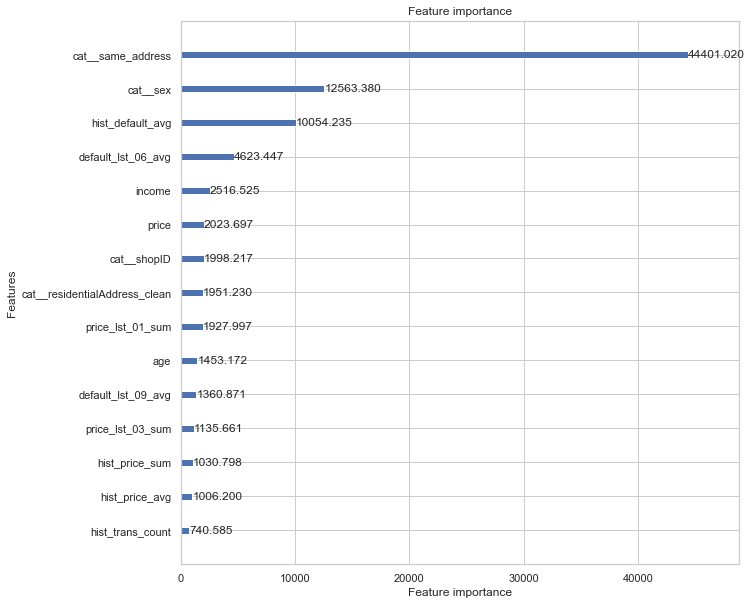

In [36]:
fig, ax2 = plt.subplots(figsize=(10,10))
lgb.plot_importance(model, max_num_features=15, ax=ax2, importance_type = 'gain')